# Face Detection Pipeline

I am building a Face Detection Pipeline using the Open CV frontal face Haar cascade detection model (as we did in week 4). 

I will improve the output in two steps:
1. Remove multiple boxes for the same face using Non-Maximum Suppression (NMS).
2. Verify that each box actually contains a face with our trained HIOG feature classifier from week 5. 


I will measure the quality of the approaches with the WIDER FACE dataset.



## Ingest the WIDER FACE label data

In [34]:
# The label data text file is structured as follows:
# - All image data are listed sequentially, with no blank lines in between.
# - The first line contains the relative path to the image.
# - The second line contains the number of faces in the image.
# - The subsequent lines contain the bounding box information for each face, formatted as "x y w h", where (x, y) is the top-left corner of the bounding box, and w and h are the width and height of the bounding box, respectively.
# - There are additional values on each box line, but we will ignore them for this task.
# - An image with 0 faces is followed by one row of 0 0 0 0 


PATH_TO_FILE = "data/wider_face_split/wider_face_train_bbx_gt.txt"
MIN_FACE_SIZE = 30  # Minimum width and height of faces to consider

image_data = []

with open(PATH_TO_FILE, "r") as f:
    line = f.readline()
    # Stop when no more lines to read
    while line:
        # First line in an image block is the image path
        image_path = line.strip()
        # Second line is the number of faces in the image
        num_faces = int(f.readline().strip())
        faces = []
        # store the bounding box information for each face in the image
        # note that if the number of faces is 0, this block is not executed
        for _ in range(num_faces):
            face_info = f.readline().strip().split()
            x, y, w, h = map(int, face_info[:4])
            # Only append faces that are bigger than 30x30 pixels
            if w >= MIN_FACE_SIZE and h >= MIN_FACE_SIZE:
                faces.append((x, y, w, h))
        # Handling the case of 0 faces: Ignore the next line which contains "0 0 0 0"
        if num_faces == 0:
            line = f.readline()
        # Add image data to the list
        image_data.append((image_path, faces))
        # Read the next image path for the next iteration (or to end the loop)
        line = f.readline()


# the format of each entry is (image_path, [(x1, y1, w1, h1), (x2, y2, w2, h2), ...])
# hence, number of faces in the image can be obtained by len(faces) for each entry, e.g., len(images[0][1]) gives the number of faces in the first image        




In [52]:
# Get a random sample of 100 images from the dataset
import random
SAMPLE_SIZE = 100
random.seed(57)
sampled_images = random.sample(image_data, SAMPLE_SIZE)


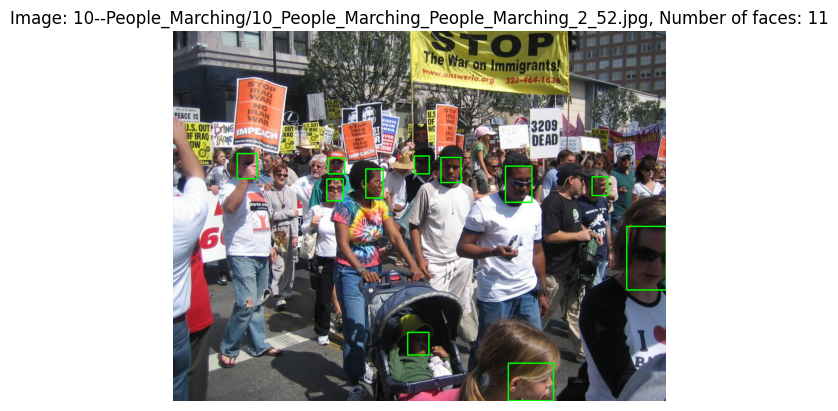

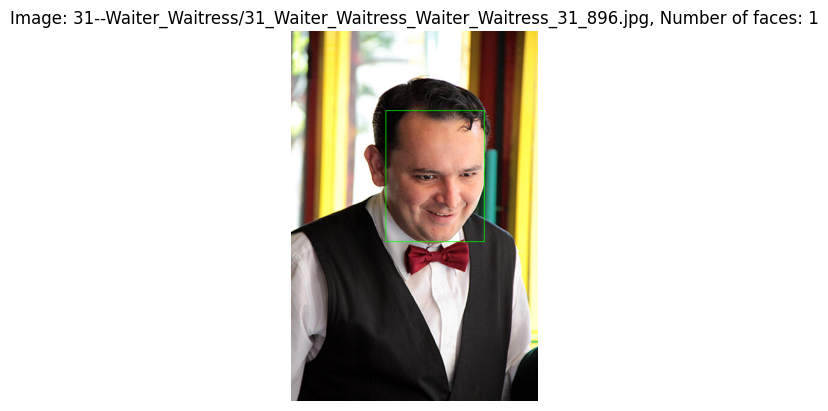

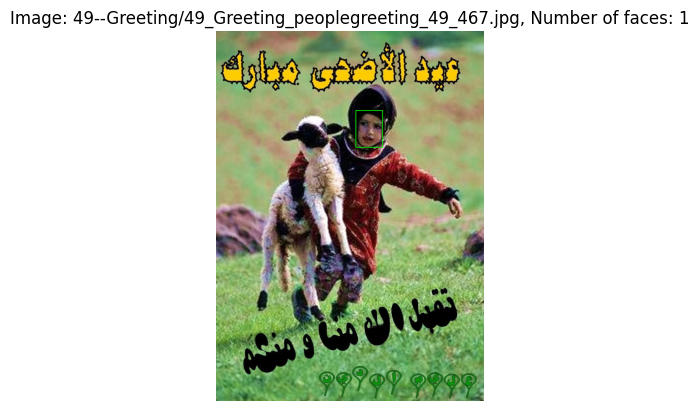

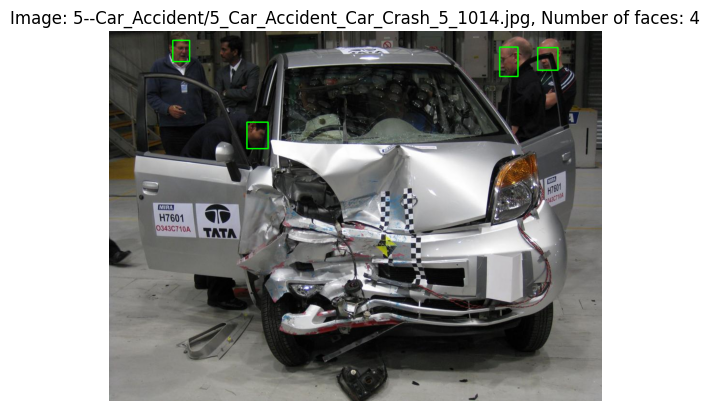

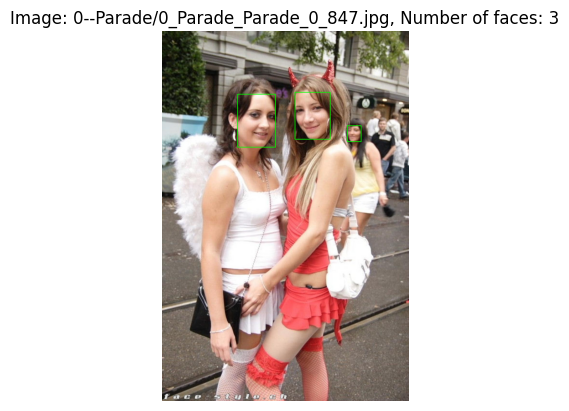

In [53]:
# Display the first 5 images and their corresponding bounding boxes
import cv2
import matplotlib.pyplot as plt 

BASE_DIR = "data/wider_train/images/"

def draw_boxes(image, boxes):
    for (x, y, w, h) in boxes:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return image    

for i in range(5):
    image_path, boxes = sampled_images[i]
    img = cv2.imread(BASE_DIR + image_path)
    img_with_boxes = draw_boxes(img, boxes)
    plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title(f"Image: {image_path}, Number of faces: {len(boxes)}")
    plt.axis('off')
    plt.show()

## IoU calculator

In order to identify whether two boxes refer to the same object (face), I calculate the "Intersection over Union" measure which calculates the overlap to total (union) size ratio. 

The measure calculates the intersection of two boxes, as well as the area that is covered by both boxes together (i.e. area of both boxes minus the intersection area to not count that twice.)

If two boxes are identical IoU is 1 (intersection = union); if they do not overlap, IoU is 0 (intersection is 0).

As different models / labelling may apply different padding to the faces, and boxes may be moved by some pixels, exact box matching cannot be expected. A standard measure to decide that two boxes box the same object is IoU > 0.5 which I will apply here. However, that value is to a degree arbitrary.

In [ ]:
def calculate_IoU(boxA, boxB):
    # boxA and boxB are in the format (x, y, w, h)

    # first calculate the coordinates of the intersection rectangle
    i_x_top_left = max(boxA[0], boxB[0])
    i_y_top_left = max(boxA[1], boxB[1])
    i_x_bottom_right = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    i_y_bottom_right = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    # Compute the area of intersection rectangle
    # If the rectangles do not overlap, i_x_bottom_right - i_x_top_left 
    # or i_y_bottom_right - i_y_top_left will be negative, 
    # so we take max with 0 to ensure non-negative area
    i_width = max(0, i_x_bottom_right - i_x_top_left)
    i_height = max(0, i_y_bottom_right - i_y_top_left)
    # If no overlap, the intersection area will be 0
    i_area = i_width * i_height

    # Compute the area of both boxes based on width * height
    boxA_area = boxA[2] * boxA[3]
    boxB_area = boxB[2] * boxB[3]

    # The union area is the sum of both areas minus the intersection area (to avoid counting the intersection twice)
    union_area = boxA_area + boxB_area - i_area

    # Avoid division by zero: IoU is 0 if union_area is 0
    # (in case both boxes are of zero area, which is a degenerate case)
    if union_area == 0:
        return 0.0  

    # Compute the intersection over union by taking the intersection area 
    # and dividing it by the sum of prediction + ground-truth areas - the interesection area
    return i_area / float(union_area)



## Non-Maximum Suppression

Implement NMS myself to remove duplicate boxes over the same object. 

Input: a list of boxes that have the coordinates (x, y, w, h), and a confidence rating or similar – a value that corresponds to the probability that the box is actually a face. 

The idea is that in case of overlapping boxes, the box with the highest confidence (probability that it is a face) should be kept (rather than e.g. the biggest box). 

To decide whether two overlapping boxes refer to the same object (face), I use the IoU measure. I arbitrarily assume that an IoU greater than 0.5 means that two boxes box in the same object. 

As a workflow, I will first sort the boxes by confidence. That allows me to dismiss boxes later in the list, which means I don't need to compare the other boxes to the dismissed ones, while having covered the boxes that are kept. 

In [ ]:
# Assume format of boxes [((x, y, w, h), confidence), ...] 
# ie. box[0] = location, box[1] = confidence score
def nms(boxes, iou_threshold):
    if not boxes:
        return []
    
    # Sort the boxes by confidence in descending order (highest confidence first)
    sorted_boxes = sorted(boxes, key=lambda b: b[1], reverse=True)
    
    unique_boxes = []
    
    # Go through the list of boxes that are sorted by confidence (highest confidence first)
    for sorted_box in sorted_boxes:
        # Add the first box to the unique_boxes list since there is no box to compare with yet
        if not unique_boxes:
            unique_boxes.append(sorted_box)
            continue
        # Otherwise, compare the current box with all the boxes in unique_boxes
        # Only add the current box to the unique box list if the IoU is smaller than the threshold
        # Assuming otherwise it is a duplicate detection.
        for unique_box in unique_boxes:
            if calculate_IoU(sorted_box[0], unique_box[0]) < iou_threshold:
                unique_boxes.append(sorted_box)

    return unique_boxes

# Accuracy Calculation

To ensure the found boxes are the the same as the labelled ones, we need to compare each found box with every labelled box. 

Because we may also see that mutiple found boxes are essentially duplicates, we also need to compare the found boxes with each other. 

Possible cases are: 
- A found box matches a label.
– Multiple found boxes match one label (duplicates.)
- Found boxes do not match a label.
(- Technically we could also track that multiple found boxes)
- A label was not found. 

In order to 

## Haar Cascade detection

In [13]:
import cv2

# Load the Haar Cascade classifier for frontal face detection
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [ ]:
def get_boxes_for_image(image_path):
    # Read the image
    img = cv2.imread(image_path)
    # Convert to grayscale as Haar Cascade works better on grayscale images
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(
        gray, 
        scaleFactor=1.1, 
        minNeighbors=5,
        minSize=(30, 30)
        )
    return faces